# Housing Price Prediction

## Problem Statement
The goal of this analysis is to identify key drivers of housing prices and estimate expected property values using structural and locational features. The model is intended to support price understanding and comparison rather than exact market valuation.

## Assumptions
1. Each property is treated as an independent observation.
2. Features contain sufficient signal.
3. Historical patterns are relevant.
4. No assumption is made about linearity, the model approximates relationships using hierarchical decision rules.
5. The model simplifies a complex real-world process and does not capture all external or unobserved features.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Read data
df=pd.read_csv("Housing.csv")
print("Shape:",df.shape)
df.head()

Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [4]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [6]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## Interpretation
- Prices are generally high but there are some high-end properties which pull the mean up.
- Most houses are moderate in size, but a few very large properties exist and may dominate splits.
- Bedrooms are fairly clustered; useful but not a strong differentiator alone.
- Bathrooms vary less than bedrooms and likely act as a secondary quality signal.
- Most houses are 1–2 stories; taller houses are rare.
- Parking is sparse and binary-like, despite being numeric.

**Summary:** Housing prices and area show strong right skew with large variability, while most structural features are clustered around common values.

In [7]:
df["mainroad"].value_counts()

mainroad
yes    468
no      77
Name: count, dtype: int64

Most houses are on a main road; being off the main road is a minority case.

In [8]:
df["guestroom"].value_counts()

guestroom
no     448
yes     97
Name: count, dtype: int64

In [9]:
df["basement"].value_counts()

basement
no     354
yes    191
Name: count, dtype: int64

In [10]:
df["hotwaterheating"].value_counts()

hotwaterheating
no     520
yes     25
Name: count, dtype: int64

Hot water heating is rare; splits on this feature may overfit unless constrained.

In [11]:
df["airconditioning"].value_counts()

airconditioning
no     373
yes    172
Name: count, dtype: int64

In [12]:
df["prefarea"].value_counts()

prefarea
no     417
yes    128
Name: count, dtype: int64

In [13]:
df["furnishingstatus"].value_counts()

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

Fairly balanced across 3 categories. This is a good categorical variable with meaningful variation.

**Summary:** Several binary amenities are unevenly distributed and may introduce sharp price differences, making a decision tree suitable for capturing threshold effects, though depth control will be necessary to avoid overfitting.

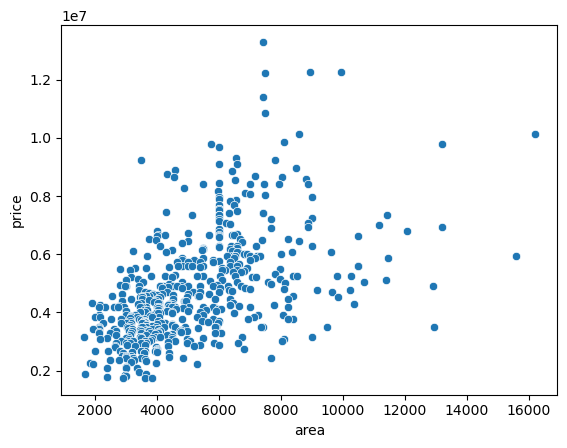

In [14]:
# Area vs Prices
sns.scatterplot(x="area",y="price",data=df)
plt.show()

**Interpretation:** Area is a strong but non-linear predictor of price, with increasing variance at higher values, making it well-suited for decision tree–based splits rather than a single global linear relationship.

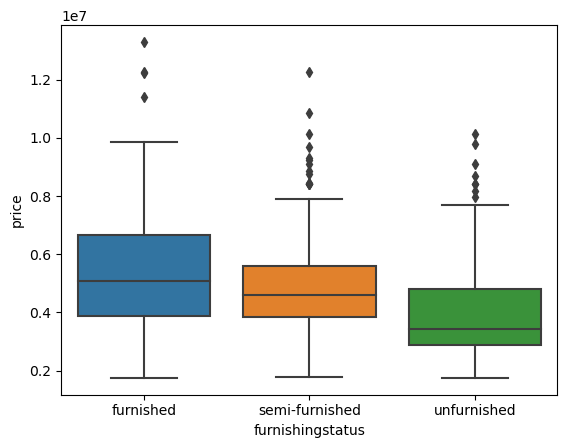

In [15]:
# Furnishing status vs price
sns.boxplot(x="furnishingstatus",y="price",data=df)
plt.show()

**Interpretation:** Furnishing status alone does not determine price; it interacts with other features such as area and location. It appears to be a meaningful categorical predictor and may form useful early or mid-level splits in a decision tree.

# Model Development & Evaluation

In [16]:
# Defining dependent and independent variables
target= "price"
X= df.drop(columns=[target])
y= df[target]

In [17]:
# Encoding categorical variables
X_encoded= pd.get_dummies(
    X,
    drop_first= True
)

In [18]:
print("Shape:",X_encoded.shape)
X_encoded.head()

Shape: (545, 13)


,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,7420,4,2,3,2,True,False,False,False,True,True,False,False
1,8960,4,4,4,3,True,False,False,False,True,False,False,False
2,9960,3,2,2,2,True,False,True,False,False,True,True,False
3,7500,4,2,2,3,True,False,True,False,True,True,False,False
4,7420,4,1,2,2,True,True,True,False,True,False,False,False


In [19]:
# Splitting training and testing data
X_train, X_test, y_train, y_test= train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [20]:
# Checking if data types are numeric
X_train.dtypes

area                               int64
bedrooms                           int64
bathrooms                          int64
stories                            int64
parking                            int64
mainroad_yes                        bool
guestroom_yes                       bool
basement_yes                        bool
hotwaterheating_yes                 bool
airconditioning_yes                 bool
prefarea_yes                        bool
furnishingstatus_semi-furnished     bool
furnishingstatus_unfurnished        bool
dtype: object

In [21]:
# Defining a formula to simplify model fitting, prediction and evaluation metrics
def evaluate(model, X_train, y_train, X_test, y_test):
    # Fit
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        "train_mae": train_mae, "train_rmse": train_rmse, "train_r2": train_r2,
        "test_mae": test_mae, "test_rmse": test_rmse, "test_r2": test_r2
    }

In [22]:
# Shallow decision tree model
shallow_tree = DecisionTreeRegressor(max_depth=3, random_state=42)

In [23]:
# Deep/unrestricted decision tree model
deep_tree = DecisionTreeRegressor(random_state=42)

In [24]:
# Balanced/regularized decision tree with moderate complexity and enough support per rule
regularized_tree = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=10,
    random_state=42
)

In [25]:
# Using the formula to evaluate and compare the models
results = {
    "shallow_tree": evaluate(shallow_tree, X_train, y_train, X_test, y_test),
    "deep_tree": evaluate(deep_tree, X_train, y_train, X_test, y_test),
    "regularized_tree": evaluate(regularized_tree, X_train, y_train, X_test, y_test)
}

results

{'shallow_tree': {'train_mae': 846732.8529837024,
  'train_rmse': 1139753.5920619632,
  'train_r2': 0.5786983648241125,
  'test_mae': 1327852.6565066273,
  'test_rmse': 1775612.1813735447,
  'test_r2': 0.37624793702041404},
 'deep_tree': {'train_mae': 8107.798165137615,
  'train_rmse': 67088.47540457372,
  'train_r2': 0.9985402884288594,
  'test_mae': 1195266.0550458715,
  'test_rmse': 1625669.904259373,
  'test_r2': 0.4771459275854347},
 'regularized_tree': {'train_mae': 725882.4430717535,
  'train_rmse': 980429.8102082352,
  'train_r2': 0.6882516089441664,
  'test_mae': 1180231.3689157541,
  'test_rmse': 1567556.5690365273,
  'test_r2': 0.513859046889446}}

## Model Interpretations
### Shallow Tree 
- On average, the model’s predictions are off by about 1.3 million in price units this is about 30% error considering the median is about 4.3M.
- RMSE>MAE which means the model makes some large errors, especially on expensive houses.
- The shallow tree explains 38% of the variance in prices. This is expected for a depth-3 tree indicating the shallow tree is intentionally under-fitting.
### Deep Tree
- The model fits the training data almost perfectly, making very small prediction errors showing clearly that it has memorized the data.
- So even though the model “knows” the training data extremely well, it still makes errors of 25–30% of a typical house price on new data. From a pricing or valuation perspective, this is risky especially for high-value properties
- Despite near-perfect training performance, test performance improves only modestly compared to the shallow tree and remains far from ideal.
- The model’s apparent accuracy on training data does not translate into reliable predictions on unseen properties.

In [32]:
# Creating a metrics comparison table for the different models
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[[
    "train_mae", "test_mae",
    "train_rmse", "test_rmse",
    "train_r2", "test_r2"
]]
comparison_df.round(2)

,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2
shallow_tree,846732.85,1327852.66,1139753.59,1775612.18,0.58,0.38
deep_tree,8107.80,1195266.06,67088.48,1625669.90,1.00,0.48
regularized_tree,725882.44,1180231.37,980429.81,1567556.57,0.69,0.51


## Interpretation
- Regularized tree has the best test R².
- Regularized tree has the lowest test RMSE.
- It has a lower train vs test R2 gap meaning less memorization.
- That means better generalization.

**Summary:** A shallow tree underfits and fails to capture sufficient structure, while an unrestricted/deep tree overfits by memorizing training data. Introducing depth and leaf-size constraints produces a balanced model that generalizes better to unseen data. The regularized decision tree achieves the best trade-off between interpretability and predictive performance. The model is good enough to support decision-making, not to replace valuation.

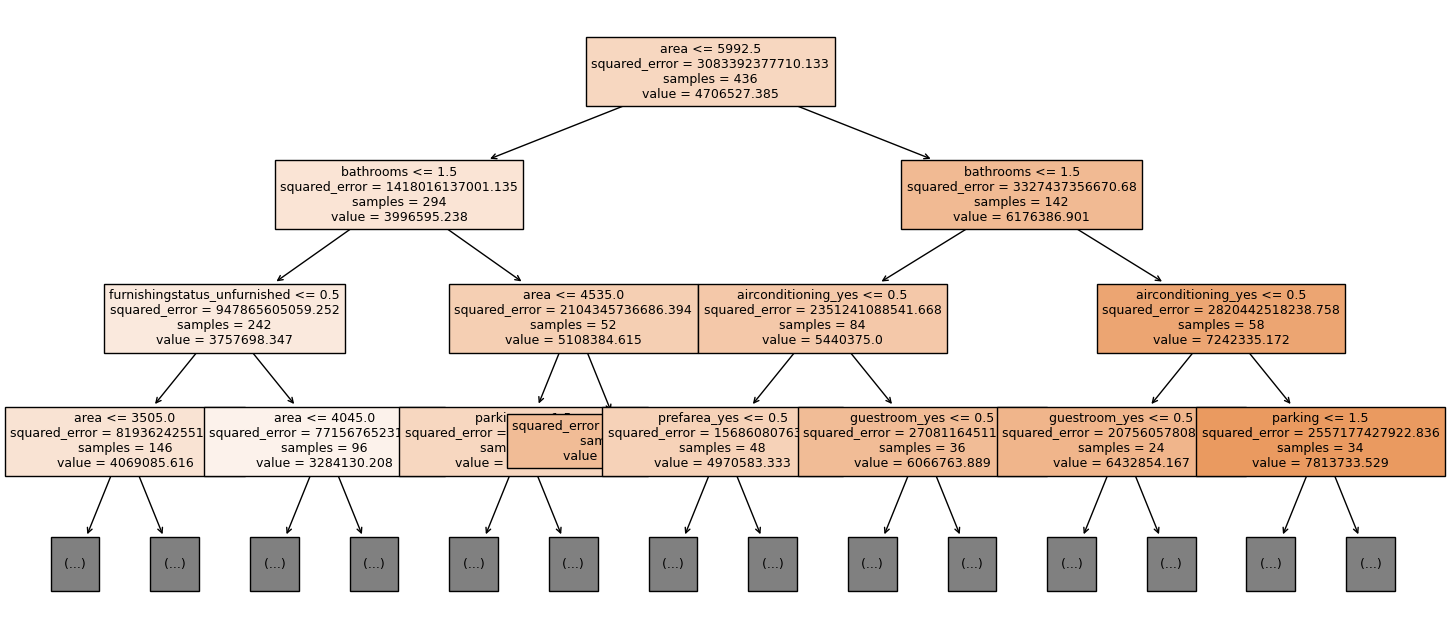

In [35]:
# Visualizing top splits in the regularized tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plot_tree(
    regularized_tree,
    feature_names= list(X_train.columns),
    filled=True,
    max_depth=3,
    fontsize=9
)
plt.show()

In [34]:
from sklearn.tree import export_text

rules = export_text(
    regularized_tree,
    feature_names=list(X_train.columns),
    max_depth=3
)
print(rules)


|--- area <= 5992.50
|   |--- bathrooms <= 1.50
|   |   |--- furnishingstatus_unfurnished <= 0.50
|   |   |   |--- area <= 3505.00
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- area >  3505.00
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- furnishingstatus_unfurnished >  0.50
|   |   |   |--- area <= 4045.00
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- area >  4045.00
|   |   |   |   |--- truncated branch of depth 3
|   |--- bathrooms >  1.50
|   |   |--- area <= 4535.00
|   |   |   |--- parking <= 1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- parking >  1.50
|   |   |   |   |--- value: [5201636.36]
|   |   |--- area >  4535.00
|   |   |   |--- value: [6061125.00]
|--- area >  5992.50
|   |--- bathrooms <= 1.50
|   |   |--- airconditioning_yes <= 0.50
|   |   |   |--- prefarea_yes <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- prefarea_yes >  0.50
|   |   |   |   |--- truncated b

In [36]:
# Checking shallow tree feature importances
importances_shall = pd.Series(
    shallow_tree.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances_shall

area                               0.611771
bathrooms                          0.303566
furnishingstatus_unfurnished       0.045870
bedrooms                           0.038793
stories                            0.000000
parking                            0.000000
mainroad_yes                       0.000000
guestroom_yes                      0.000000
basement_yes                       0.000000
hotwaterheating_yes                0.000000
airconditioning_yes                0.000000
prefarea_yes                       0.000000
furnishingstatus_semi-furnished    0.000000
dtype: float64

## Shallow Tree Feature Importance
- Area is the most influential feature in the tree, as it accounts for the largest reduction in prediction error across splits.
- The tree relies primarily on area and bathrooms, unfurnished houses and bedrooms to make its splits. All other variables were not used within the first three levels of the tree.
- Area has strong threshold effects, Bathrooms is a strong quality proxy, Depth is too shallow to include secondary features.

**Summary:** A shallow decision tree regressor explains approximately 38% of the variance in housing prices, relying primarily on area and number of bathrooms for its splits. This indicates that size-related features are dominant early drivers of price. The limited depth intentionally underfits the data, excluding secondary amenities and resulting in higher prediction errors, particularly for high-priced properties.

In [37]:
# Checking deep tree feature importance 
importances_deep = pd.Series(
    deep_tree.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances_deep

area                               0.483606
bathrooms                          0.175930
stories                            0.053482
airconditioning_yes                0.043854
bedrooms                           0.042743
parking                            0.037394
furnishingstatus_unfurnished       0.034336
prefarea_yes                       0.034289
basement_yes                       0.026027
guestroom_yes                      0.025045
hotwaterheating_yes                0.018138
furnishingstatus_semi-furnished    0.017841
mainroad_yes                       0.007316
dtype: float64

## Deep Tree Feature Importance
- Many features now have non-zero importance as compared to the shallow tree.
- Hence as the tree grows deeper, it begins to rely on increasingly specific and lower-signal features, indicating that it is fitting noise rather than robust price drivers.

**Summary:** The unrestricted decision tree achieves near-perfect performance on the training data, indicating memorization rather than learning general patterns. While test performance improves slightly compared to a shallow tree, the large gap between training and test metrics highlights over-fitting. Feature importance becomes more dispersed, with several lower-signal and rare features contributing to splits, suggesting the model is capturing noise rather than stable price drivers. This demonstrates the need for regularization when using decision trees for price prediction.

**Note:** Decision trees are powerful at capturing non-linear relationships and interactions, but without constraints they easily over-fit, achieving excellent training performance while failing to generalize.

In [38]:
# Checking regularized tree feature importance
importances_reg = pd.Series(
    regularized_tree.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances_reg

area                               0.577041
bathrooms                          0.204801
airconditioning_yes                0.055710
parking                            0.046584
furnishingstatus_unfurnished       0.038569
guestroom_yes                      0.038000
prefarea_yes                       0.019833
basement_yes                       0.008952
mainroad_yes                       0.008394
bedrooms                           0.002115
stories                            0.000000
hotwaterheating_yes                0.000000
furnishingstatus_semi-furnished    0.000000
dtype: float64

# Analytical Interpretation of the findings
The regularized decision tree identifies area as the most influential feature, indicating that house size is the primary factor used to segment prices. Number of bathrooms emerges as the second most important driver, suggesting that functional capacity and quality further differentiate prices within size categories. Secondary features such as air conditioning, parking availability, furnishing status, and guest rooms contribute smaller but meaningful refinements to price predictions, primarily within already-defined segments rather than as standalone drivers. Features with near-zero importance were not selected for splits under the imposed constraints, implying that they add limited incremental value once stronger predictors are accounted for.

# Business Interpretation
The model suggests that pricing strategies and valuation decisions should prioritize size and bathroom count as primary drivers, while amenities should be used to adjust prices within comparable property categories rather than as standalone indicators.

# Author 
## Wanjiru Kamau